## Project Description

While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.
By looking at the demographics of traﬃc accident victims for each US state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of states with similar profiles. How can we find such groups in a statistically sound way and communicate the result effectively?

## Project Tasks

1. The raw data files and their format
2. Read in and get an overview of the data
3. Create a textual and a graphical summary of the data
4. Quantify the association of features and accidents
5. Fit a multivariate linear regression
6. Perform PCA on standardized data
7. Visualize the first two principal components
8. Find clusters of similar states in the data
9. KMeans to visualize clusters in the PCA scatter plot
10. Visualize the feature differences between the clusters
11. Compute the number of accidents within each cluster
12. Make a decision when there is no clear right choice

## 1. The raw data files and their format

In [1]:
import os
os.listdir()

['.ipynb_checkpoints',
 'miles-driven.csv',
 'Reducing Traffic Mortality.ipynb',
 'road-accidents.csv']

## 2. Read in and get an overview of the data

### Road Accidents

In [2]:
import pandas as pd

accident_filepath = 'road-accidents.csv'

acc_data = pd.read_csv(accident_filepath ,comment = '#', sep = '|')


In [3]:
acc_data.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,Alabama,18.8,39,30,80
1,Alaska,18.1,41,25,94
2,Arizona,18.6,35,28,96
3,Arkansas,22.4,18,26,95
4,California,12.0,35,28,89


In [4]:
acc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 51 non-null     object 
 1   drvr_fatl_col_bmiles  51 non-null     float64
 2   perc_fatl_speed       51 non-null     int64  
 3   perc_fatl_alcohol     51 non-null     int64  
 4   perc_fatl_1st_time    51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB


### Miles Driven

In [5]:
import pandas as pd

miles_filepath = 'miles-driven.csv'

ml_data = pd.read_csv(miles_filepath, sep = '|')


In [6]:
ml_data.head()

,state,million_miles_annually
0,Alabama,64914
1,Alaska,4593
2,Arizona,59575
3,Arkansas,32953
4,California,320784


In [7]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   state                   51 non-null     object
 1   million_miles_annually  51 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 944.0+ bytes


## 3. Create a textual and a graphical summary of the data

We now have an idea of what the dataset looks like. To further familiarize ourselves with this data, we will calculate summary statistics and produce a graphical overview of the data. The graphical overview is good to get a sense for the distribution of variables within the data and could consist of one histogram per column. It is often a good idea to also explore the pairwise relationship between all columns in the data set by using a using pairwise scatter plots (sometimes referred to as a "scatterplot matrix").

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Road Accidents

In [9]:
summ_road = acc_data.describe()
print(summ_road)

       drvr_fatl_col_bmiles  perc_fatl_speed  perc_fatl_alcohol  \
count             51.000000        51.000000          51.000000   
mean              15.790196        31.725490          30.686275   
std                4.122002         9.633438           5.132213   
min                5.900000        13.000000          16.000000   
25%               12.750000        23.000000          28.000000   
50%               15.600000        34.000000          30.000000   
75%               18.500000        38.000000          33.000000   
max               23.900000        54.000000          44.000000   

       perc_fatl_1st_time  
count            51.00000  
mean             88.72549  
std               6.96011  
min              76.00000  
25%              83.50000  
50%              88.00000  
75%              95.00000  
max             100.00000  


<Figure size 1152x432 with 0 Axes>

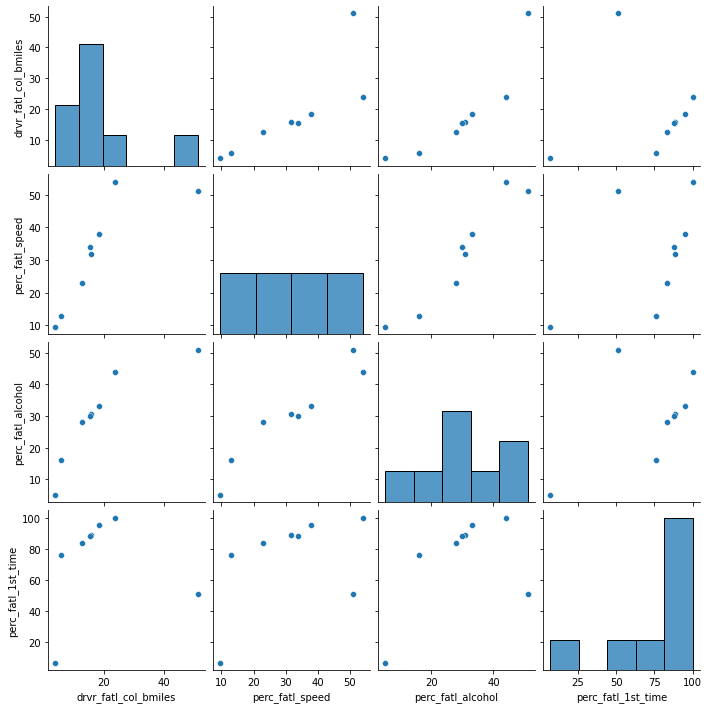

In [10]:
plt.figure(figsize=(16,6))

sns.pairplot(summ_road)

### Miles Driven

In [11]:
summ_ml = ml_data.describe()
print(summ_ml)

       million_miles_annually
count               51.000000
mean             57851.019608
std              59898.414088
min               3568.000000
25%              17450.000000
50%              46606.000000
75%              71922.500000
max             320784.000000


<AxesSubplot:xlabel='million_miles_annually', ylabel='state'>

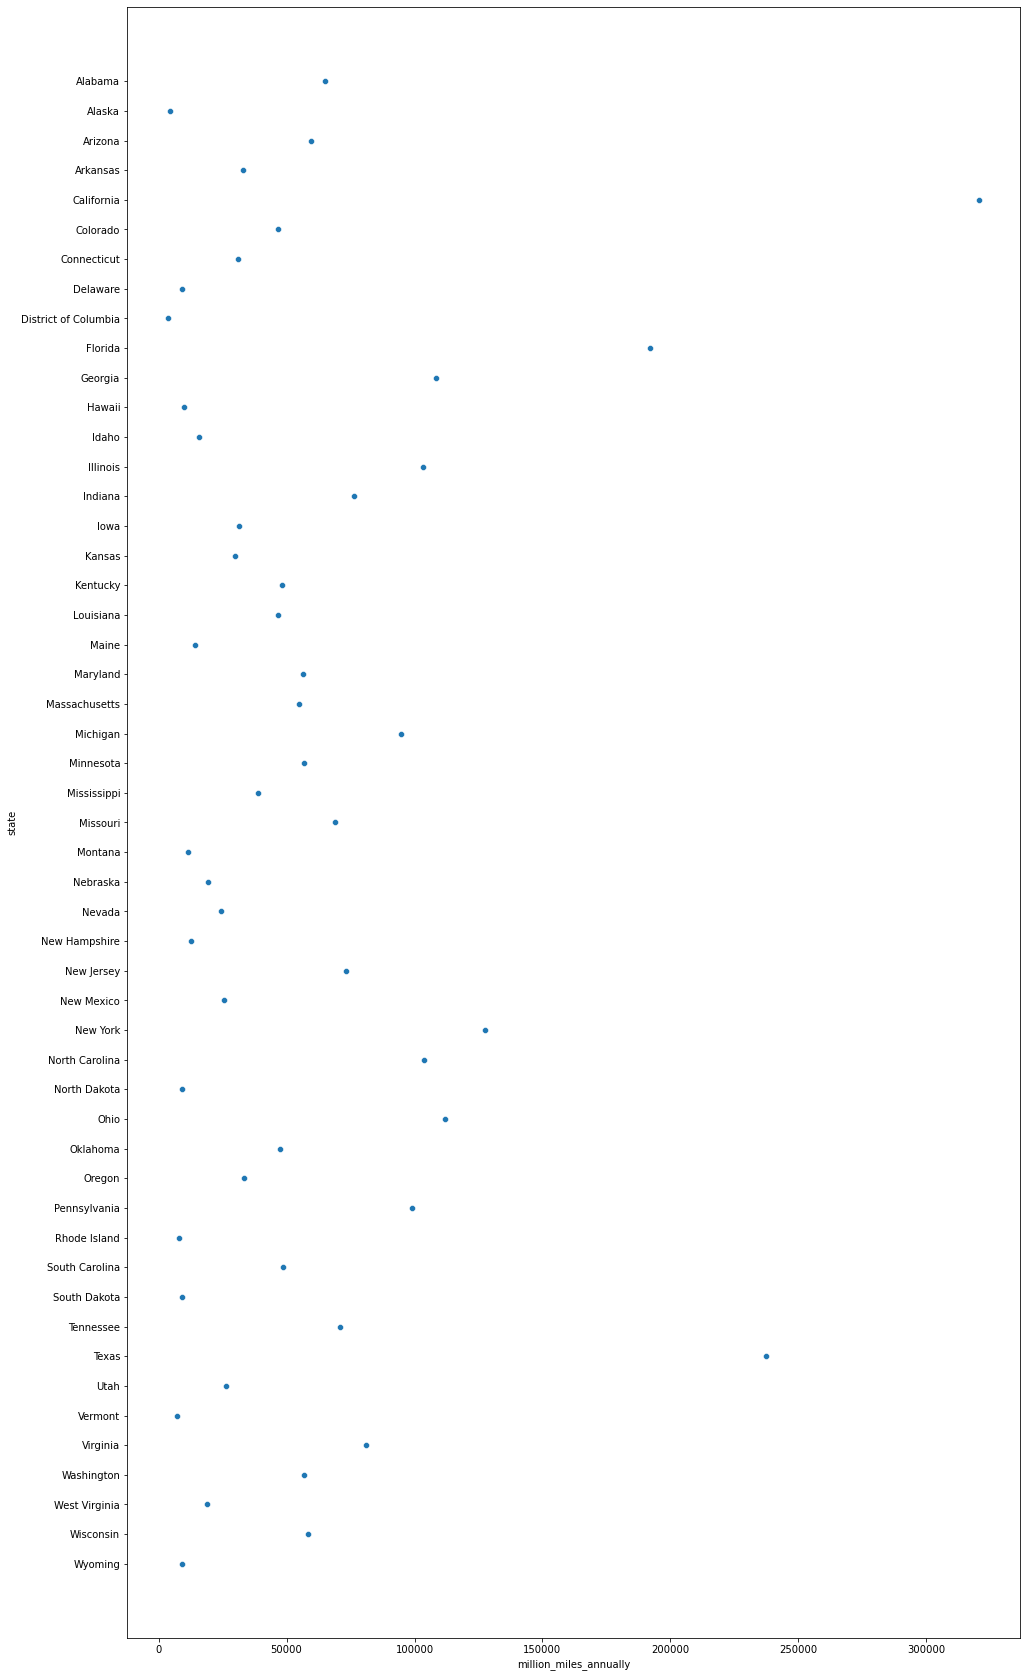

In [12]:
plt.figure(figsize=(16,30))

sns.scatterplot(x=ml_data['million_miles_annually'], y=ml_data['state'])

## 4. Quantify the association of features and accidents

We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).
To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:
0.2 = weak
0.5 = medium
0.8 = strong
0.9 = very strong

In [13]:
corre = acc_data.corr()
corre

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000


<AxesSubplot:>

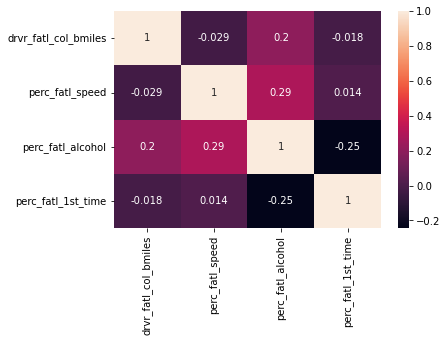

In [14]:
sns.heatmap(data=corre, annot=True) 

## 5. Fit a Multivariate Linear Regression

From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row). But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This can be done using multivariate linear regression.
Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.
 A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A->B->Y) can overwhelm the direct correlation (A->Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a masking relationship. Let’s see if the multivariate regression can reveal such a phenomenon.

In [15]:
from sklearn.linear_model import LinearRegression

target_variable = acc_data['drvr_fatl_col_bmiles']
feature_variable = acc_data[['perc_fatl_speed','perc_fatl_alcohol','perc_fatl_1st_time']]

model = LinearRegression()
model.fit(feature_variable,target_variable)

print("Regression Coefficients")
print(model.coef_)

Regression Coefficients
[-0.04180041  0.19086404  0.02473301]


## 6. Perform PCA on Standardized Data

We have learned that alcohol consumption is weakly associated with the number of fatal accidents across states. This could lead us to conclude that alcohol consumption should be a focus for further investigations and maybe strategies should divide states into high versus low alcohol consumption in accidents. But there are also associations between alcohol consumptions and the other two features, so it might be worth trying to split the states in a way that accounts for all three features.
One way of clustering the data is to use PCA to visualize data in reduced dimensional space where we can try to pick up patterns by eye. PCA uses the absolute variance to calculate the overall variance explained for each principal component, so it is important that the features are on a similar scale (unless we would have a particular reason that one feature should be weighted more).
We'll use the appropriate scaling function to standardize the features to be centered with mean 0 and scaled with standard deviation 1.

In [16]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features_variable_scaled = ss.fit_transform(feature_variable)

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(features_variable_scaled)

PCA()

In [18]:
import numpy as np
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    print("Cumulative Variances")
    print(cv)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

Cumulative Variances
[0.4567308  0.79469786 1.        ]


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

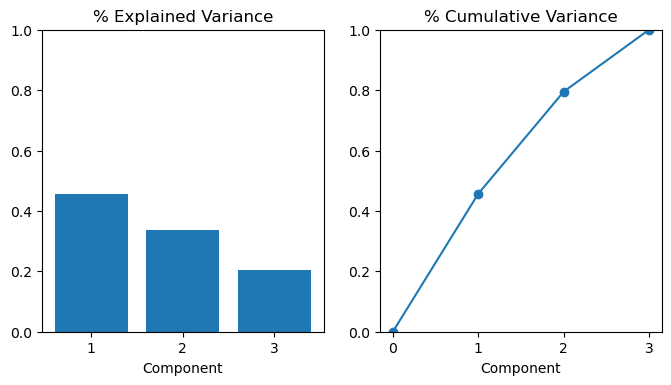

In [19]:
plot_variance(pca)

## 7. Visualize the First Two Principal Components

The first two principal components enable visualization of the data in two dimensions while capturing a high proportion of the variation (79%) from all three features: speeding, alcohol influence, and first-time accidents. This enables us to use our eyes to try to discern patterns in the data with the goal to find groups of similar states. Although clustering algorithms are becoming increasingly efficient, human pattern recognition is an easily accessible and very efficient method of assessing patterns in data.
We will create a scatter plot of the first principle components and explore how the states cluster together in this visualization.

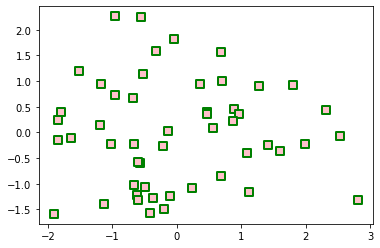

In [20]:

pca = PCA(n_components = 2)
p_comps = pca.fit_transform(features_variable_scaled)

p_comp1 = p_comps[:, 0]
p_comp2 = p_comps[:, 1]

plt.scatter(p_comp1, p_comp2,c ="pink",linewidths = 2,marker ="s",edgecolor ="green",s = 50)

## 8. Find Clusters of Similar States in the Data


It was not entirely clear from the PCA scatter plot how many groups in which the states cluster. To assist with identifying a reasonable number of clusters, we can use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.

C:\Users\Umair\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Umair\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Umair\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Umair\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmea

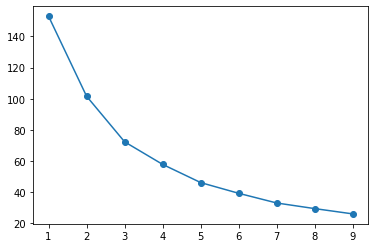

In [21]:
from sklearn.cluster import KMeans

clusterrange = range(1, 10)
powers = []
for item in clusterrange:
    km = KMeans(n_clusters=item, random_state=8)
    km.fit(features_variable_scaled)
    powers.append(km.inertia_)
    
plt.plot(clusterrange, powers, marker='o')

## 9. KMeans to visualize clusters in the PCA scatter plot

Since there wasn't a clear elbow in the scree plot, assigning the states to either two or three clusters is a reasonable choice, and we will resume our analysis using three clusters. Let's see how the PCA scatter plot looks if we color the states according to the cluster to which they are assigned.

C:\Users\Umair\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Cluster
0,Alabama,18.8,39,30,80,0
1,Alaska,18.1,41,25,94,2
2,Arizona,18.6,35,28,96,2
3,Arkansas,22.4,18,26,95,2
4,California,12.0,35,28,89,2


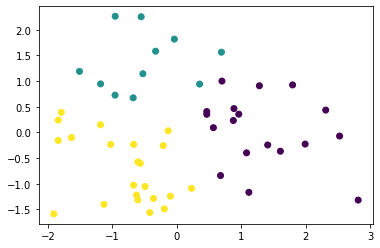

In [22]:
km = KMeans(n_clusters = 3, random_state = 8)

acc_data["Cluster"] = km.fit_predict(features_variable_scaled)
acc_data["Cluster"] = acc_data["Cluster"].astype("category")

plt.scatter(p_comps[:, 0], p_comps[:, 1], c = km.labels_)

acc_data.head()

## 10. Visualize the feature differences between the clusters

Thus far, we have used both our visual interpretation of the data and the KMeans clustering algorithm to reveal patterns in the data, but what do these patterns mean?
Remember that the information we have used to cluster the states into three distinct groups are the percentage of drivers speeding, under alcohol influence and that has not previously been involved in an accident. We used these clusters to visualize how the states group together when considering the first two principal components. This is good for us to understand structure in the data, but not always easy to understand, especially not if the findings are to be communicated to a non-specialist audience.
A reasonable next step in our analysis is to explore how the three clusters are different in terms of the three features that we used for clustering. Instead of using the scaled features, we return to using the unscaled features to help us interpret the differences.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='percent', ylabel='measurement'>

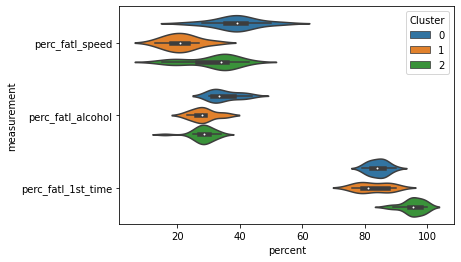

In [23]:
melt_car = pd.melt(acc_data, id_vars = ['Cluster'], var_name ='measurement', value_name = 'percent', 
                                                   value_vars =['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'])

sns.violinplot(melt_car['percent'], melt_car['measurement'], hue = melt_car['Cluster'])

## 11. Compute the number of accidents within each cluster

Now it is clear that different groups of states may require different interventions. Since resources and time are limited, it is useful to start off with an intervention in one of the three groups first. Which group would this be? To determine this, we will include data on how many miles are driven in each state, because this will help us to compute the total number of fatal accidents in each state. Data on miles driven is available in another tab-delimited text file. We will assign this new information to a column in the DataFrame and create a violin plot for how many total fatal traffic accidents there are within each state cluster.

In [46]:
acc_miles = acc_data.merge(ml_data, on='state')
acc_miles['num_drvr_fatl_col'] = (acc_miles['drvr_fatl_col_bmiles'] * acc_miles['million_miles_annually']) / 1000
print(acc_miles.head())
count = acc_miles.groupby('Cluster')['num_drvr_fatl_col'].agg(['count','sum'])
print(count)

        state  drvr_fatl_col_bmiles  perc_fatl_speed  perc_fatl_alcohol  \
0     Alabama                  18.8               39                 30   
1      Alaska                  18.1               41                 25   
2     Arizona                  18.6               35                 28   
3    Arkansas                  22.4               18                 26   
4  California                  12.0               35                 28   

   perc_fatl_1st_time Cluster  million_miles_annually  num_drvr_fatl_col  
0                  80       0                   64914          1220.3832  
1                  94       2                    4593            83.1333  
2                  96       2                   59575          1108.0950  
3                  95       2                   32953           738.1472  
4                  89       2                  320784          3849.4080  
         count         sum
Cluster                   
0           18  16405.3159
1           11   9

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='count', ylabel='Cluster'>

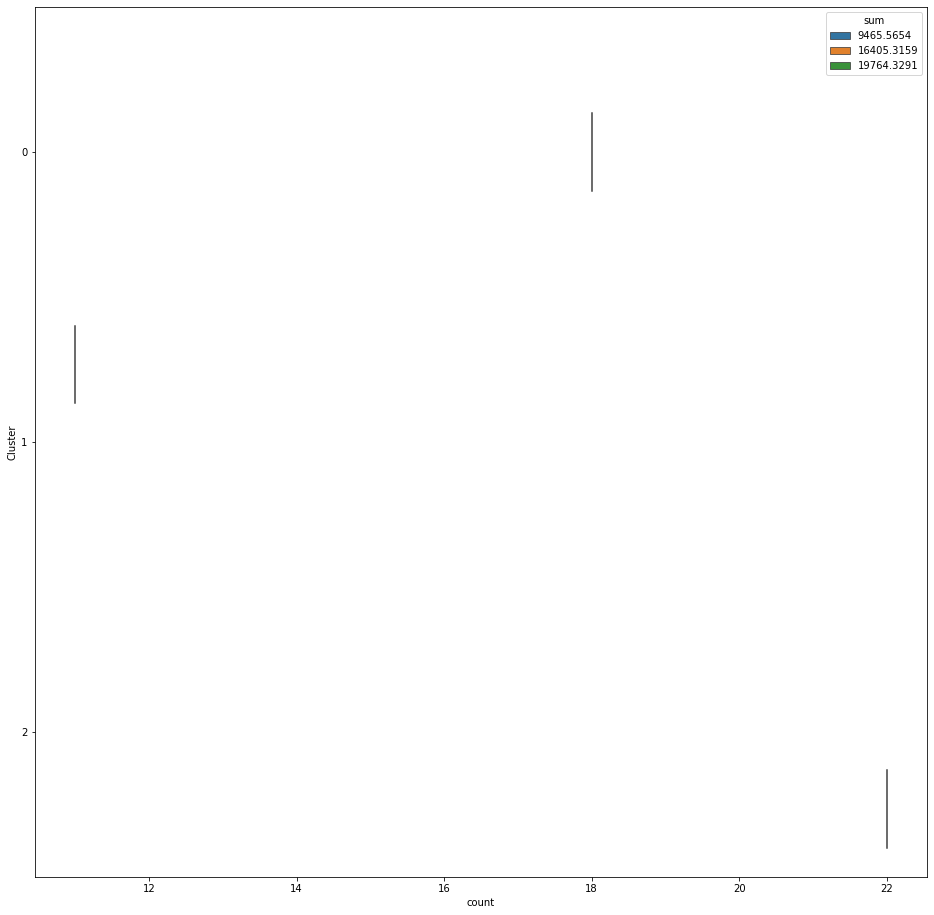

In [52]:
plt.figure(figsize=(16,16))
sns.violinplot(count['count'],count.index, count['sum'])

## 12. Make a decision when there is no clear right choice

As we can see, there is no obvious correct choice regarding which cluster is the most important to focus on. Yet, we can still argue for a certain cluster and motivate this using our findings above. Which cluster do you think should be a focus for policy intervention and further investigation?


I think we should focus on cluster 0 and cluster 2 because there are greater number of accidents in these clusters so we can use these for further investigation due to greater data.